<a href="https://colab.research.google.com/github/MrKri03/Computer_Image_UT/blob/main/Assignment_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Using CNN's For Image classification using Cats vs Dogs Dataset

Creating a Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities.

You will also create some helper functions to move the images around the filesystem so if you are not familiar with the `os` module be sure to take a look a the [docs](https://docs.python.org/3/library/os.html).


In [45]:
import os
import zipfile #to open zip files
import random
import shutil
from shutil import copyfile
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [46]:
# Specific libraries
import cv2
from skimage.color import rgb2gray
from skimage import color, data
import matplotlib.pyplot as plt
from scipy.ndimage import filters
from skimage.filters import gaussian
from PIL import Image

Download the dataset from its original source by running the cell below. 

Note that the `zip` file that contains the images is unzipped under the `/tmp` directory.

In [47]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-03-13 10:23:22--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.28.136.225, 2600:1408:9000:6ac::317f, 2600:1408:9000:68a::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.28.136.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   118MB/s    in 6.8s    

2023-03-13 10:23:29 (116 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [50]:
!ls /tmp/PetImages/

Cat  Dog


Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [51]:
# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir('/tmp/PetImages/Dog'))} images of dogs.")
print(f"There are {len(os.listdir('/tmp/PetImages/Cat'))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


You will need a directory for cats-v-dogs, and subdirectories for training
and validation. These in turn will need subdirectories for 'cats' and 'dogs'. To accomplish this, complete the `create_train_val_dirs` below:

In [52]:
# Function to create directories:
def create_directory(root_dir):
  # Empty directory to prevent FileExistsError is the function is run several times
  if not os.path.exists(root_dir):
    os.makedirs(root_dir, exist_ok = True)
    

The following paths will have the train-validation

In [58]:
# Directory of modified images (images with transformations applied):

root_modified= '/tmp/PetImages_modified'


In [59]:
# Create directories with folders for each animal 

create_directory(os.path.join(root_modified,"Cat"))
create_directory(os.path.join(root_modified,"Dog"))

In [60]:
## Here are the functions to apply the filters: 

#
def read_image(input_image,name_image,folder):
  """
  function to read the image 

  Args:
    input_image (string) - the path where the image is stored
  Returns:
    read_image: This is a cv2 image
    None value: if reading the image is not successful
  """
  try:
    read_image = cv2.imread(input_image)
    return read_image
  except:
    print(f'The image {name_image} in folder {folder} cannot be read')
    return None


#
def sobel_filter(input_image, output_dir, name_image):
  """
  Creates a sobel filter on the images and stores the result in the folder
  Args:
    input_image - cv2 image
    output_dir (string) - the output directory where the image is going to be stored
    name_image (string) - the name of the image and format of output
  Returns:
    None
  """
  image_to_sobel = filters.sobel(input_image)
  plt.imsave(os.path.join(output_dir,name_image.split(".")[0]+"_sob.jpg"),image_to_sobel)

#
def gauss_filter(input_image, output_dir, name_image):
  from skimage.filters import gaussian
  
  """
  Creates a gauss filter on the images and stores the result in the folder
  Args:
    input_image - cv2 image
    output_dir (string) - the output directory where the image is going to be stored
    name_image (string) - the name of the image and format of output
  Returns:
    void
  """
  image_to_gauss = gaussian(input_image, channel_axis=3)
  plt.imsave(os.path.join(output_dir,name_image.split(".")[0] +"_gss.jpg"),image_to_gauss)

#
def black_white(input_image, output_dir,name_image):
  """
  Creates a black and white image and stores the result in the folder
  Args:
    input_image - cv2 image
    output_dir (string) - the output directory where the image is going to be stored
    name_image (string) - the name of the image and format of output
  Returns:
    void
  """
  image_to_bw = color.rgb2gray(input_image)
  plt.imsave(os.path.join(output_dir,name_image.split(".")[0]+"_BW.jpg"),image_to_bw)

def upscale(input_image, output_dir,name_image):
  """
  Applies a transformation to upscale the image
  Args:
    input_image - cv2 image
    output_dir (string) - the output directory where the image is going to be stored
    name_image (string) - the name of the image and format of output
  Returns:
    void
  """
  # We use a constant factor to upscale the image. Interpolation: INTER_CUBIC

  factor = 2
  
  upscaled_img = cv2.resize(input_image, None, fx=factor, fy=factor, interpolation=cv2.INTER_CUBIC)

  cv2.imwrite(os.path.join(output_dir,name_image.split(".")[0]+"_up.jpg"),upscaled_img)


def downscale(input_image, output_dir,name_image):
  """
  Applies a transformation to upscale the image
  Args:
    input_image  - cv2 image
    output_dir (string) - the output directory where the image is going to be stored
    name_image (string) - the name of the image and format of output
  Returns:
    void
  """
  # We use a constant factor to downscale the image. Interpolation: INTER_CUBIC

  factor = 2
  
  Dscaled_img = cv2.resize(input_image, None,  fx=1/factor, fy=1/factor, interpolation=cv2.INTER_CUBIC)

  cv2.imwrite(os.path.join(output_dir,name_image.split(".")[0]+"_down.jpg"),Dscaled_img)


#Define a function to apply the type of processing to images
def apply_processing(transformation, input_image, output_directory, name_file):
  """
  Executes one of the image transformation functions, according to the name_filter argument
  Args:
    transformation (string) - the name of the transformation to use. Only 5 posssible options: black_white, gaussian, sobel, up, down
    input_image  - cv2 image
    output_directory (string) - the path to store the result image
    name_file (string) - the name of the input file with extension
  Returns:
    void
  """



  if transformation == "black_white":
    black_white(input_image, output_directory, name_file)

  elif transformation == "gaussian":
    gauss_filter(input_image, output_directory, name_file)

  elif transformation == "sobel":
    sobel_filter(input_image, output_directory, name_file)

  elif transformation == "up":
    upscale(input_image, output_directory, name_file)

  elif transformation == "down":
    downscale(input_image, output_directory, name_file)

  else:
    print("please specify the name of the filter you want to apply to the image")
    pass



In [61]:
animals = ["Cat","Dog"]
# the images from the original folder to be passed to the function apply_processing(). Repeats for Cat and Dog

transformation = "down" # Which transformation to use

In [62]:
# Carry out the whole process

# Loop through Cat and Dog folder
for animal in animals:
  
  print("Folder:",animal)
  original_images = os.path.join('/tmp/PetImages',animal)

  for file_name in os.listdir(original_images):
    
    #This function has one try - except block
    image = read_image(os.path.join(original_images,file_name),
                         file_name,animal)
    
    try:
      #try to apply the filter.
      apply_processing(transformation,image,
                       os.path.join(root_modified,animal),
                       file_name)
                        
    except Exception as e:
      # go to the next image and see what image has failed.
      print(f'The transformation {transformation} for image {file_name} could not be done') # If the JPG does not have the correct configuration. Prints out the name of the image
      continue

Folder: Cat
The transformation down for image 3491.jpg could not be done
The transformation down for image 2663.jpg could not be done
The transformation down for image 850.jpg could not be done
The transformation down for image 10501.jpg could not be done
The transformation down for image 4833.jpg could not be done
The transformation down for image 11874.jpg could not be done
The transformation down for image 7968.jpg could not be done
The transformation down for image 666.jpg could not be done
The transformation down for image 10820.jpg could not be done
The transformation down for image 9171.jpg could not be done
The transformation down for image 8470.jpg could not be done
The transformation down for image 9565.jpg could not be done
The transformation down for image 9778.jpg could not be done
The transformation down for image 660.jpg could not be done
The transformation down for image 11210.jpg could not be done
The transformation down for image 10404.jpg could not be done
The transf

In [65]:
## Check that all the images are in the new folders :
print(len(os.listdir("/tmp/PetImages_modified/Cat")))
print(len(os.listdir("/tmp/PetImages_modified/Dog")))

12476
12470


In [66]:
# General path to store all the images for analysis with the Network
dir_analysis = "/tmp/cats-v-dogs"

In [67]:

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(path_to_images):
  """
  Creates directories for the train and test sets
  Args:
    root_path (string) - the base directory path to create subdirectories from
  Returns:
    None
  """
  try:
    os.makedirs(path_to_images, exist_ok=True)
    os.makedirs(os.path.join(path_to_images,"training"), exist_ok=True)
    os.makedirs(os.path.join(path_to_images,"validation"), exist_ok=True)
    os.makedirs(os.path.join(path_to_images,"training","cats"), exist_ok=True)
    os.makedirs(os.path.join(path_to_images,"training","dogs"), exist_ok=True)
    os.makedirs(os.path.join(path_to_images,"validation","cats"), exist_ok=True)
    os.makedirs(os.path.join(path_to_images,"validation","dogs"), exist_ok=True)
  except OSError:
  # HINT:
  # Use os.makedirs to create your directories with intermediate subdirectories
  # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter
    pass
  
try:
  create_train_val_dirs(dir_analysis)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [68]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [69]:
# Test your create_train_val_dirs function
for rootdir, dirs, files in os.walk(dir_analysis):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/validation/cats


Code the `split_data` function which takes in the following arguments:
- SOURCE_DIR: directory containing the files

- TRAINING_DIR: directory that a portion of the files will be copied to (will be used for training)
- VALIDATION_DIR: directory that a portion of the files will be copied to (will be used for validation)
- SPLIT_SIZE: determines the portion of images used for training.

The files should be randomized, so that the training set is a random sample of the files, and the validation set is made up of the remaining files.

For example, if `SOURCE_DIR` is `PetImages/Cat`, and `SPLIT_SIZE` is .9 then 90% of the images in `PetImages/Cat` will be copied to the `TRAINING_DIR` directory
and 10% of the images will be copied to the `VALIDATION_DIR` directory.

All images should be checked before the copy, so if they have a zero file length, they will be omitted from the copying process. If this is the case then your function should print out a message such as `"filename is zero length, so ignoring."`. **You should perform this check before the split so that only non-zero images are considered when doing the actual split.**


Hints:

- `os.listdir(DIRECTORY)` returns a list with the contents of that directory.

- `os.path.getsize(PATH)` returns the size of the file

- `copyfile(source, destination)` copies a file from source to destination

- `random.sample(list, len(list))` shuffles a list

In [70]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training
    
  Returns:
    None
  """

  files = []
  #Discard the zero length images.
  for filename in os.listdir(SOURCE_DIR):
        file_name = os.path.join(SOURCE_DIR, filename)
        if os.path.getsize(file_name) > 0:
            files.append(filename)
        else:
            print("{} has zero length so discarding".format(filename))

  train_set_size = int(len(files)*SPLIT_SIZE)
  shuffled_data = random.sample(files, len(files))  #Randomly shuffle the data
  training_data = shuffled_data[0:train_set_size]
  validation_data = shuffled_data[train_set_size:len(files)]

  for file in training_data:
     src_file = os.path.join(SOURCE_DIR, file)
     des_file = os.path.join(TRAINING_DIR, file)
     copyfile(src_file, des_file)
  
  for file in validation_data:
      src_file = os.path.join(SOURCE_DIR, file)
      des_file = os.path.join(VALIDATION_DIR, file)
      copyfile(src_file, des_file)      
  pass

In [71]:
# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages_modified/Cat" # Modified images
DOG_SOURCE_DIR = "/tmp/PetImages_modified/Dog" # Modified images

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")



Original cat's directory has 12476 images
Original dog's directory has 12470 images

There are 11228 images of cats for training
There are 11223 images of dogs for training
There are 1248 images of cats for validation
There are 1247 images of dogs for validation


Now that you have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation. For this, complete the `train_val_generators` function below.

Something important to note is that the images in this dataset come in a variety of resolutions. Luckily, the `flow_from_directory` method allows you to standarize this by defining a tuple called `target_size` that will be used to convert each image to this target resolution. **Use a `target_size` of (150, 150)**.

**Hint:** 

Don't use data augmentation by setting extra parameters when you instantiate the `ImageDataGenerator` class. This will make the training of your model to take longer to reach the necessary accuracy threshold to pass this assignment and this topic will be covered in the next week.

In [72]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class with rescale argument.
  # rescale is a value by which we will multiply the data before any other processing. 
  # Our original images consist in RGB coefficients in the 0-255,
  # but such values would be too high for our models to process (given a typical learning rate), 
  # so we target values between 0 and 1 instead by scaling with a 1/255. factor.

  train_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropiate arguments to the flow_from_directory method, set target size to 150,150 as 
  # The dimensions to which all images found will be resized.
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=50,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class with rescale argument to resize the image to 255)
  validation_datagen = ImageDataGenerator(rescale = 1/255)

  # Pass in the appropiate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=50,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator


In [73]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22451 images belonging to 2 classes.
Found 2495 images belonging to 2 classes.


One last step before training is to define the architecture of the model that will be trained.

Complete the `create_model` function below which should return a Keras' `Sequential` model.

we should also compile it to make sure to use a `loss` function that is compatible with the `class_mode` we defined, which should also be compatible with the output of the network. 

**Note that we should use at least 3 convolution layers to achieve the desired performance.**

Also Note that because we are facing a two-class classification problem, i.e. a binary classification problem, we will end the network with a sigmoid activation fucntion. The output of the network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [ ]:
################################ Convert the Images to Gray Scale ##############################
################  You can use use color.rgb2gray ######################################


In [74]:
def create_model():
  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation= 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation= 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation= 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation = 'relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])
  
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001), 
                loss='binary_crossentropy',
                metrics=['accuracy']) 
  return model


Now it is time to train your model!

**Note:** You can ignore the `UserWarning: Possibly corrupt EXIF data.` warnings.

In [75]:
print(create_model().summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 64)      

In [76]:
NUMBER_EPOCHS = 3 # takes time to finish the model training

In [77]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs= NUMBER_EPOCHS, 
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/3
450/450 [==============================] - 748s 2s/step - loss: 0.6284 - accuracy: 0.6330 - val_loss: 0.5738 - val_accuracy: 0.6910
Epoch 2/3
450/450 [==============================] - 726s 2s/step - loss: 0.4868 - accuracy: 0.7640 - val_loss: 0.4186 - val_accuracy: 0.8008
Epoch 3/3
450/450 [==============================] - 692s 2s/step - loss: 0.4040 - accuracy: 0.8141 - val_loss: 0.3581 - val_accuracy: 0.8421


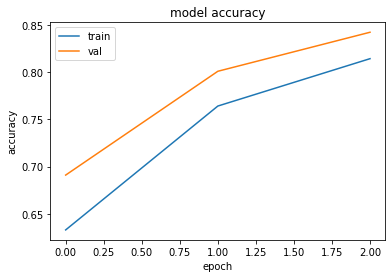

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
from google.colab import files

from matplotlib import pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("DOWN_accuracy.png")
plt.show()

files.download("DOWN_accuracy.png") 

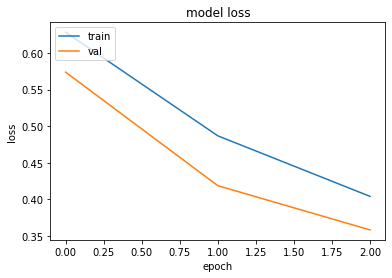

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("down_loss.png")

plt.show()
files.download("down_loss.png") 

You will probably encounter that the model is overfitting, which means that it is doing a great job at classifying the images in the training set but struggles with new data. This is perfectly fine and you will learn how to mitigate this issue in the upcoming week.

Before downloading this notebook and closing the assignment, be sure to also download the `history.pkl` file which contains the information of the training history of your model. You can download this file by running the cell below:

In [84]:
def download_history():
  import pickle
  from google.colab import files

  with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

  files.download('model.pkl')

download_history()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
......max_pooling2d_3
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
## Delete the folder, so other analysis can be done: 
shutil.rmtree("/tmp/PetImages_modified")


In [83]:
## Delete the folder, so other analysis can be done: 
shutil.rmtree( "/tmp/cats-v-dogs")